# Statistics for Hackers

### An Exploration of Statistics Through Computational Simulation

#### A [talk][video] by [Jake VanDerPlas][jakevdp] for PyCon 2016
#### [Slides][slides] available on speakerdeck


## Motivation

There's no shortage of absolutely magnificent material out there on the topics of data science and machine learning for an autodidact, such as myself, to learn from. In fact, so many great resources exist that an individual can be forgiven for not knowing where to even begin their studies, or for getting distracted once they're off the starting block. I honestly can't count the number of times that I've started working through many of these online courses and tutorials only to have my attention stolen by one of the multitudes of amazing articles on data analysis with Python, or some great new [MOOC][mooc] on Deep Learning. But this year is different! This year I've decided to create a data science curriculum and stick to it. I'm no longer going to casually sign up for another course, or start reading yet another textbook just to be distracted part way through. 

As part of my data science curriculum, I've chosen to start with [Harvard's Data Science course][cs109]. I'm currently on week 3 and one of the suggested readings for this week is [Jake VanderPlas'][jakevdp] talk from PyCon 2016 titled "Statistics for Hackers". As I was watching the [video][video] and following along with the [slides][slides], I wanted to try out some of the examples and create a set of notes that I could refer to at a later date, so I figured why not create a Jupyter notebook. Once I'd finished, I realized I'd created a decently-sized resource that could be of use to others working their way through the talk. I did a quick google search and nothing similar turned up, so I decided to release my notebook. The result is the article you're reading right now, the remainder of which contains my notes and code examples for Jake's excellent talk. 

So, enjoy the article, I hope you find this resource useful, and if you have any problems or suggestions of any kind, the full notebook can be found on [github][github], so please send me a [pull request][github_pulls], or submit an [issue][github_issues], or just message me directly on [Twitter][twitter].

[mooc]: https://en.wikipedia.org/wiki/Massive_open_online_course
[cs109]: http://cs109.github.io/2015/index.html
[video]: https://youtu.be/Iq9DzN6mvYA
[slides]: https://speakerdeck.com/jakevdp/statistics-for-hackers
[jakevdp]: https://staff.washington.edu/jakevdp/
[github]: https://github.com/croach/statistics-for-hackers
[github_pulls]: https://github.com/croach/statistics-for-hackers/pulls
[github_issues]: https://github.com/croach/statistics-for-hackers/issues
[twitter]: https://twitter.com/vthakr


## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Suppress all warnings just to keep the notebook nice and clean. 
# This must happen after all imports since numpy actually adds its
# RankWarning class back in.
import warnings
warnings.filterwarnings("ignore")

# Setup the look and feel of the notebook
sns.set_context("notebook", 
                font_scale=1.5, 
                rc={"lines.linewidth": 2.5})
sns.set_style('whitegrid')
sns.set_palette('deep')

# Create a couple of colors to use throughout the notebook
red = sns.xkcd_rgb['vermillion']
blue = sns.xkcd_rgb['dark sky blue']

from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Warm-up

The talk starts off with a motivating example that asks the question "If you toss a coin **30** times and see **22** heads, is it a fair coin?"

Well, a fair coin should show roughly 15 heads in 30 tosses, so it does seem likely that the coin is biased. However, the skeptic might argue that even a fair coin could show 22 heads in 30 tosses from time-to-time, this may just be a chance event. So, the question would then be "how can you determine if you are tossing a fair coin?"

### The Classic Method

The classic method would assume that the skeptic is correct and would then test the hypothesis (called the [*Null Hypothesis*][null_hypothesis]) that the observation of 22 heads in 30 tosses could happen simply due to chance. To do so, we would first calculate the probability of a fair coin coming up heads in 22 out of 30 tosses.

Let's start by first computing the probability of flipping heads in a single coin toss.

$$
P(H) = \frac{1}{2}
$$

The probability of a single coin toss turning up heads is exactly 50% since there is an equal chance of either heads or tails turning up.

Now, to determine the probability of getting 2 heads in a row with 2 coin tosses, we would need to multiply the probability of getting heads by the probability of getting heads again since the two events are independent of one atnother.

$$
P(HH) = P(H) \cdot P(H) = P(H)^2 = \left(\frac{1}{2}\right)^2 = \frac{1}{4}
$$

From the equation above, we can see that the probability of getting 2 heads in a row from a total of 2 coin tosses is 25%. 

Let's now take the intuition that we've been building up and go one step further. Let's calculate the probablility of getting 2 heads and 1 tails with 3 coin tosses.

$$
P(HHT) = P(H)^2 \cdot P(T) = \left(\frac{1}{2}\right)^2 \cdot \frac{1}{2} = \left(\frac{1}{2}\right)^3 = \frac{1}{8}
$$

The equation above tells us that the probability of getting 2 heads and 1 tails in 3 tosses is 12.5%, but we have a problem; it only tells us the probability of getting tails last. In other words, the probability above is only for a single permutation of 2 heads and 1 tails and not for all of the different ways in which we can toss a coin 3 times and get 2 heads and 1 tails. To get that probability we will have to add the probabilities for all of the possible permutations, of which there are exactly three: HHT, HTH, and THH. 

$$
P(2H,1T) = P(HHT) + P(HTH) + P(THH) = \frac{1}{8} + \frac{1}{8} + \frac{1}{8} = \frac{3}{8}
$$

Another way we could do this is to calculate the total number of permutations and simply multiply that by the probability of each event happening. To get the total number of permutations we can use the [binomial coefficient][binom_coeff]. Then we can simply calculate the probability above using the following equation.

$$
P(2H,1T) = \binom{3}{2} \left(\frac{1}{2}\right)^{3} = 3 \left(\frac{1}{8}\right) = \frac{3}{8}
$$

While the equation above works in our particular case, where each event has an equal probability of happening, it will run into trouble with events that have an uneven probability of taking place. To deal with those situations, you'll want to extend the last equation to take into account the differing probabilities. The result would be the following equation, where $N$ is number of coin flips, $N_H$ is the number of expected heads, and $P_H$ is the probability of getting heads on each flip.

$$
P(N_H,N_T) = \binom{N}{N_H} \left(P_H\right)^{N_H} \left(1 - P_H\right)^{N_T}
$$

Now that we understand the classic method, let's give it a try. The following code sets up a handful of helper functions that we'll use to create the probability distribution for a fair coin being flipped 30 times using the equations we just discussed above.

[null_hypothesis]: https://en.wikipedia.org/wiki/Null_hypothesis
[binom_coeff]: https://en.wikipedia.org/wiki/Binomial_coefficient

In [2]:
def factorial(n):
    """Calculates the factorial of `n`
    """
    vals = list(range(1, n + 1))
    if len(vals) <= 0:
        return 1

    prod = 1
    for val in vals:
        prod *= val
        
    return prod
    
    
def n_choose_k(n, k):
    """Calculates the binomial coefficient
    """
    return factorial(n) / (factorial(k) * factorial(n - k))


def binom_prob(n, k, p):
    """Returns a probability based for a given set of permutations.
    
    Arguments:
    
    n - number of trials
    k - number of trials in which an event took place
    p - probability of an event happening
    
    """
    return n_choose_k(n, k) * p**k * (1 - p)**(n - k)

Now that we have a method that will calculate the probability for a specific event (e.g., 22 heads in 30 coin tosses), we can calculate the probability of every possible outcome and plot the probability distribution.

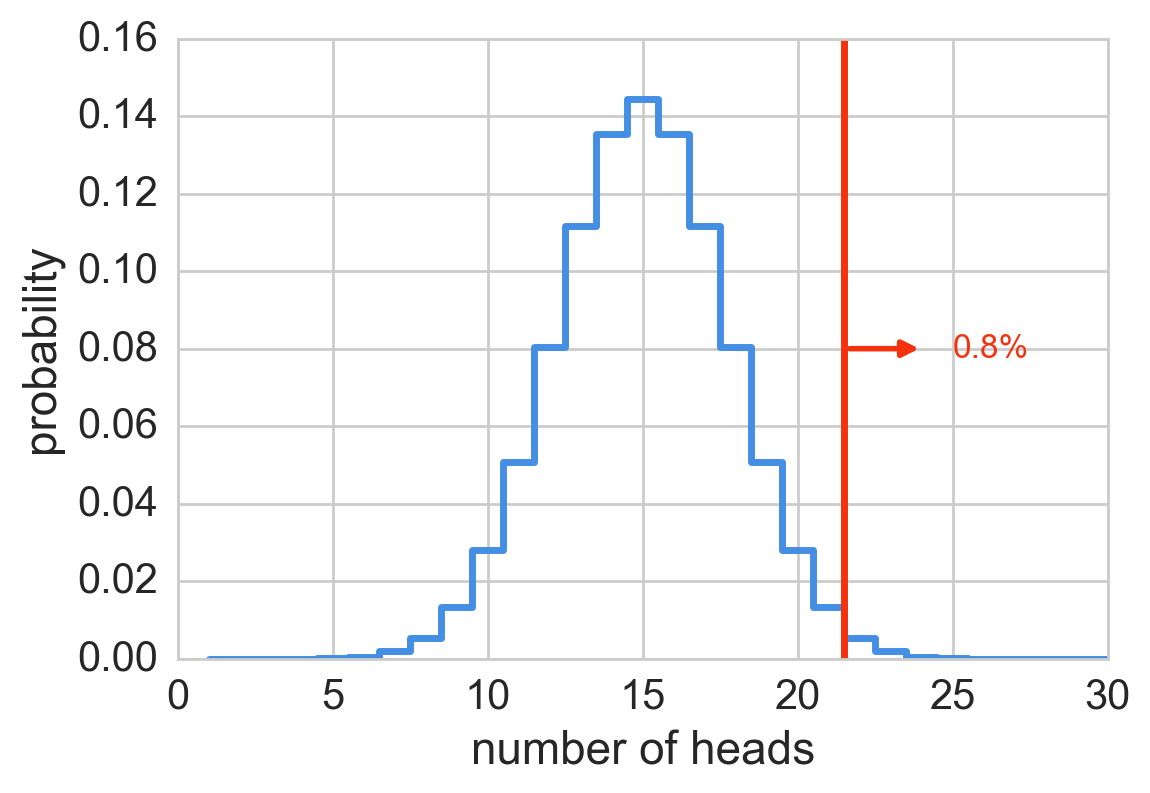

In [3]:
# Calculate the probability for every possible outcome of tossing 
# a fair coin 30 times.
probabilities = [binom_prob(30, k, 0.5) for k in range(1, 31)]

# Plot the probability distribution using the probabilities list 
# we created above.
plt.step(range(1, 31), probabilities, where='mid', color=blue)
plt.xlabel('number of heads')
plt.ylabel('probability')
plt.plot((21.5, 21.5), (0, 0.1599), color=red);
plt.annotate('0.8%', 
             xytext=(25, 0.08), 
             xy=(21.5, 0.08), 
             multialignment='right',
             va='center',
             color=red,
             size='large',
             arrowprops={'arrowstyle': '<|-', 
                         'lw': 2, 
                         'color': red, 
                         'shrinkA': 10});

#### What's a p-value?

In [statistical hypothesis testing][hypothesis_test], we have an idea that we want to test, but considering that it's very hard to prove something to be true beyond doubt, rather than test it directly, we test something called a [null hypothesis][null_hypothesis] instead. The null hypothesis essentially assumes that the effect we're seeing in the data could just be due to chance. We determine that this is true by calculating the probability that we could see an effect as extreme as what we are seeing in the data (or more so), and if that probability is above a predetermined level (historically 5%), we accept the null hypothesis, i.e., our hypothesis was invalid. Otherwise, if the probability is lower than our stated number, we reject the null hypothesis, which means that it is *possible* our hypothesis is correct. The probability that we calculated is what's known as the [p-value][p_value].

The red line above shows the p-value associated with our null hypothesis that a fair coin will result in 22 heads in 30 tosses simply by chance. In our example above, the probability of getting 22 heads when flipping a coin 30 times is roughly 0.5%. The p-value, however, is the probability of seeing a result equal to the one we are testing, or more extreme. To get the p-value then, we will need to add up the probabilities of getting 22 heads, 23 heads, 24 heads, and so on, and the function below does does exactly that.

[null_hypothesis]: https://en.wikipedia.org/wiki/Null_hypothesis
[hypothesis_test]: https://en.wikipedia.org/wiki/Statistical_hypothesis_testing
[p_value]: https://www.statisticsdonewrong.com/data-analysis.html#the-power-of-p-values

In [4]:
def p_value(n, k, p):
    """Returns the p-value for the given the given set 
    """
    return sum(binom_prob(n, i, p) for i in range(k, n+1))

print("P-value: %0.1f%%" % (p_value(30, 22, 0.5) * 100))

P-value: 0.8%


Running the code above gives us a p-value of roughly 0.8%, which is the value that we've called out in the probability distribution above.

### The Easier Method

That's an example of the classic method that we can use to test if our coin is fair or not. However, if you don't happen to have at least some background in statistics, it can be a little hard to follow at times, but luckily for us, there's an easier method...

Simulation!


The code below seeks to answer the question of whether or not our coin is fair by running a large number of simulated coin flips and calculating the proportion of these experiments that resulted in at least 22 heads or more.

In [5]:
M = 0
n = 50000
for i in range(n):
    trials = np.random.randint(2, size=30)
    if (trials.sum() >= 22):
        M += 1
p = M / n

print("Simulated P-value: %0.1f%%" % (p * 100))

Simulated P-value: 0.8%


The result of our set of simulations is 0.8%, the exact same result we got earlier when we calculated the p-value using the classical method above. 

## Four Recipes for Hacking Statistics

We've just seen one example of how our hacking skills can make it easy for us to answer questions that typically only a statistician would be able to answer using the classical methods of statistical analysis. This is just one possible method for answering statistical questions using our coding skills, but Jake's talk describes four recipes in total for "hacking statistics", each of which is listed below. The rest of this article will go into each of the remaining techniques in some detail.

1. [Direct Simulation](#Warm-up)
2. [Shuffling](#Shuffling)
3. [Bootstrapping](#Bootstrapping)
4. [Cross Validation](#Cross-Validation)

In the [Warm-up](#Warm-up) section above, we saw an example direct simulation, the first recipe in our tour of statistical hacks. The next example uses the Shuffling method to figure out if there's a statistically significant difference between two different sample populations. 

### Shuffling

In this example, we look at the Dr. Seuss story about the Star-belly Sneetches. In this Seussian world, a group of creatures called the Sneetches are divided into two groups: those with stars on their bellies, and those with no "stars upon thars". Over time, the star-bellied sneetches had come to think of themselves as better than the plain-bellied sneetches. As researchers of sneetches, it's our job to uncover whether or not star-bellied sneetches really are better than their plain-bellied cousins.

The first step in answering this question will be to create our experimental data. In the following code snippet we create a dataframe object that contains a set of test scores for both star-bellied and plain-bellied sneetches. 

In [6]:
import pandas as pd

df = pd.DataFrame({'star':  [1, 1, 1, 1, 1, 1, 1, 1] + 
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   'score': [84, 72, 57, 46, 63, 76, 99, 91] +
                            [81, 69, 74, 61, 56, 87, 69, 65, 66, 44, 62, 69]})
df

,score,star
0,84,1
1,72,1
2,57,1
3,46,1
4,63,1
5,76,1
6,99,1
7,91,1
8,81,0
9,69,0


If we then take a look at the average scores for each group of sneetches, we will see that there's a difference in scores of **6.6** between the two groups. So, on average, the star-bellied sneetches performed better on their tests than the plain-bellied sneetches. But, the real question is, is this a significant difference?

In [7]:
star_bellied_mean = df[df.star == 1].score.mean()
plain_bellied_mean = df[df.star == 0].score.mean()

print("Star-bellied Sneetches Mean: %2.1f" % star_bellied_mean)
print("Plain-bellied Sneetches Mean: %2.1f" % plain_bellied_mean)
print("Difference: %2.1f" % (star_bellied_mean - plain_bellied_mean))

Star-bellied Sneetches Mean: 73.5
Plain-bellied Sneetches Mean: 66.9
Difference: 6.6


To determine if this is a signficant difference, we could perform a [t-test][t_test] on our data to compute a p-value, and then just make sure that the p-value is less than the target 0.05. Alternatively, we could use simulation instead. 

Unlike our first example, however, we don't have a generative function that we can use to create our probability distribution. So, how can we then use simulation to solve our problem?

Well, we can run a bunch of simulations where we randomly **shuffle** the labels (i.e., star-bellied or plain-bellied) of each sneetch, recompute the difference between the means, and then determine if the proportion of simulations in which the difference was at least as extreme as 6.6 was less than the target 5%. If so, we can conclude that the difference we see is, in fact, one that doesn't occur strictly by chance very often and so the difference is a significant one. In other words, if the proportion of simulations that have a difference of 6.6 or greater is more than 5%, we can conclude that the labels really do matter, and so we can conclude that star-bellied sneetches are "better" than their plain-bellied counterparts.

[t_test]: https://en.wikipedia.org/wiki/Student's_t-test

In [8]:
df['label'] = df['star']

num_simulations = 10000

differences = []
for i in range(num_simulations):
    np.random.shuffle(df['label'])
    star_bellied_mean = df[df.label == 1].score.mean()
    plain_bellied_mean = df[df.label == 0].score.mean()
    differences.append(star_bellied_mean - plain_bellied_mean)

Now that we've ran our simulations, we can calculate our p-value, which is simply the proportion of simulations that resulted in a difference greater than or equal to 6.6.

$$
p = \frac{N_{>6.6}}{N_{total}} = \frac{1583}{10000} = 0.16
$$

In [9]:
p_value = sum(diff >= 6.6 for diff in differences) / num_simulations
print("p-value: %2.2f" % p_value)

p-value: 0.16


Since our p-value is greater than 0.05, we can conclude that the difference in test scores between the two groups is not a significant one. In other words, if having a star on your belly actually mattered, we wouldn't expect to see as many simulations result in a difference at least as extreme as the one in the real sample population. 

The following code plots the distribution of the differences we found by running the simulations above. We've also added an annotation that marks where the difference of 6.6 falls in the distribution along with its corresponding p-value.

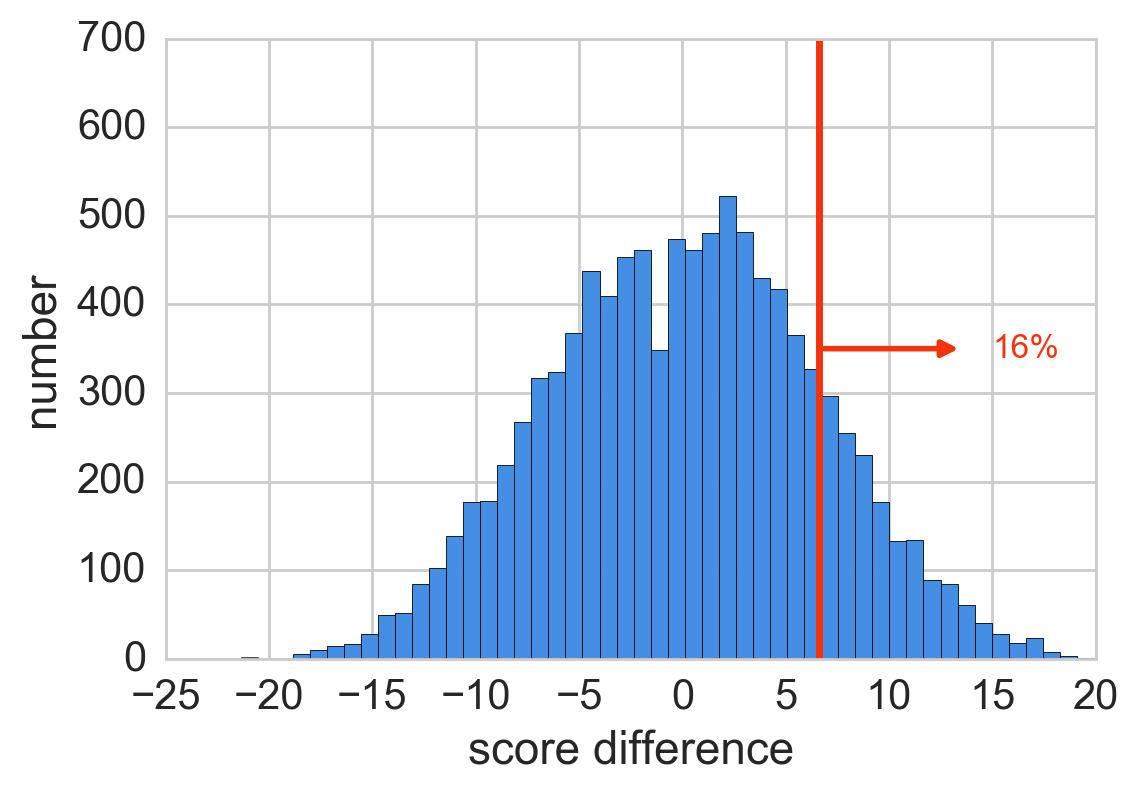

In [10]:
plt.hist(differences, bins=50, color=blue)
plt.xlabel('score difference')
plt.ylabel('number')
plt.plot((6.6, 6.6), (0, 700), color=red);
plt.annotate('%2.f%%' % (p_value * 100), 
             xytext=(15, 350), 
             xy=(6.6, 350), 
             multialignment='right',
             va='center',
             color=red,
             size='large',
             arrowprops={'arrowstyle': '<|-', 
                         'lw': 2, 
                         'color': red, 
                         'shrinkA': 10});

We can see from the histogram above---and from our simulated p-value, which was greater than 5%---that the difference that we are seeing between the populations can be explained by random chance, so we can effectively dismiss the difference as not statistically significant. In short, star-bellied sneetches are no better than the plain-bellied ones, at least not from a statistical point of view.

For further discussion on this method of simulation, check out John Rauser's keynote talk ["Statistics Without the Agonizing Pain"][rauser] from Strata + Hadoop 2014. Jake mentions that he drew inspiration from it in his talk, and it is a really excellent talk as well; I wholeheartedly recommend it.

[rauser]: https://youtu.be/5Dnw46eC-0o

### Bootstrapping

In this example, we'll be using the story of Yertle the Turtle to explore the bootstrapping recipe. As the story goes, in the land of Sala-ma-Sond, Yertle the Turtle was the king of the pond and he wanted to be the most powerful, highest turtle in the land. To achieve this goal, he would stack turtles as high as he could in order to stand upon their backs. As observers of this curious behavior, we've recorded the heights of 20 turtle towers and we've placed them in a dataframe in the following bit of code.

In [11]:
df = pd.DataFrame({'heights': [48, 24, 51, 12, 21, 
                               41, 25, 23, 32, 61, 
                               19, 24, 29, 21, 23, 
                               13, 32, 18, 42, 18]})

The questions we want to answer in this example are: what is the mean height of Yertle's turtle stacks, and what is the uncertainty of this estimate?

#### The Classic Method

The classic method is simply to calculate the sample mean...

$$
\bar{x} = \frac{1}{N} \sum_{i=1}^{N} x_i = 28.9
$$

...and the standard error of the mean.

$$
\sigma_{\bar{x}} = \frac{1}{
    \sqrt{N}}\sqrt{\frac{1}{N - 1}
    \sum_{i=1}^{N} (x_i - \bar{x})^2
} = 3.0
$$

But, being hackers, we'll be using simulation instead.

Just like in our last example, we are once again faced with the problem of not having a generative model, but unlike the last example, we're not comparing two groups, so we can't just shuffle around labels here, instead we'll use something called [bootstrap][bootstrap] [resampling][resampling].

Bootstrap resampling is a method that simulates several random sample distributions by drawing samples from the current distribution with replacement, i.e., we can draw the same data point more than once. Luckily, pandas makes this super easy with its `sample` function. We simply need to make sure that we pass in `True` for the `replace` argument to sample from our dataset with replacement.

[bootstrap]: https://en.wikipedia.org/wiki/Bootstrapping_(statistics)
[resampling]: https://en.wikipedia.org/wiki/Resampling_(statistics)

In [12]:
sample = df.sample(20, replace=True)
print("Mean: %2.2f" % sample.heights.mean())
print("Standard Error: %2.2f" % (sample.heights.std() / np.sqrt(len(sample))))
sample

Mean: 29.50
Standard Error: 3.12


,heights
19,18
13,21
10,19
14,23
4,21
12,29
10,19
11,24
4,21
8,32


More than likely the mean and standard error from our freshly drawn sample above didn't exactly match the one that we calculated using the classic method beforehand. But, if we continue to resample several thousand times and take a look at the average (mean) of all those sample means and their standard deviation, we should have something that very closely approximates the mean and standard error derived from using the classic method above.

In [13]:
xbar = []
for i in range(10000):
    sample = df.sample(20, replace=True)
    xbar.append(sample.heights.mean())
    

print("Mean: %2.1f" % np.mean(xbar))
print("Standard Error: %2.1f" % np.std(xbar))

Mean: 28.8
Standard Error: 2.9


### Cross Validation

For the final example, we dive into the world of the Lorax. In the story of the Lorax, a faceless creature sales an item that (presumably) all creatures need called a Thneed. Our job as consultants to Onceler Industries is to project Thneed sales. But, before we can get started forecasting the sales of Thneeds, we'll first need some data. 

Lucky for you, I've already done the hard work of assembling that data in the cell below by "eyeballing" the data in the scatter plot from the slides of the talk. So, it may not be exactly the same, but it should be close enough for our example analysis.

In [14]:
df = pd.DataFrame({
    'temp': [22, 36, 36, 38, 44, 45, 47,
             43, 44, 45, 47, 49,
             52, 53, 53, 53, 54, 55, 55, 55, 56, 57, 58, 59,
             60, 61, 61.5, 61.7, 61.7, 61.7, 61.8, 62, 62, 63.4, 64.6,
             65, 65.6, 65.6, 66.4, 66.9, 67, 67, 67.4, 67.5, 68, 69, 
             70, 71, 71, 71.5, 72, 72, 72, 72.7, 73, 73, 73, 73.3, 74, 75, 75, 
             77, 77, 77, 77.4, 77.9, 78, 78, 79,
             80, 82, 83, 84, 85, 85, 86, 87, 88,
             90, 90, 91, 93, 95, 97,
             102, 104],
    'sales': [660, 433, 475, 492, 302, 345, 337,
              479, 456, 440, 423, 269,
              331, 197, 283, 351, 470, 252, 278, 350, 253, 253, 343, 280,
              200, 194, 188, 171, 204, 266, 275, 171, 282, 218, 226, 
              187, 184, 192, 167, 136, 149, 168, 218, 298, 199, 268,
              235, 157, 196, 203, 148, 157, 213, 173, 145, 184, 226, 204, 250, 102, 176,
              97, 138, 226, 35, 190, 221, 95, 211,
              110, 150, 152, 37, 76, 56, 51, 27, 82,
              100, 123, 145, 51, 156, 99,
              147, 54]
})

Now that we have our sales data in a pandas dataframe, we can take a look to see if any trends show up. Plotting the data in a scatterplot, like the one below, reveals that a relationship does in fact exist between temperature and Thneed sales.

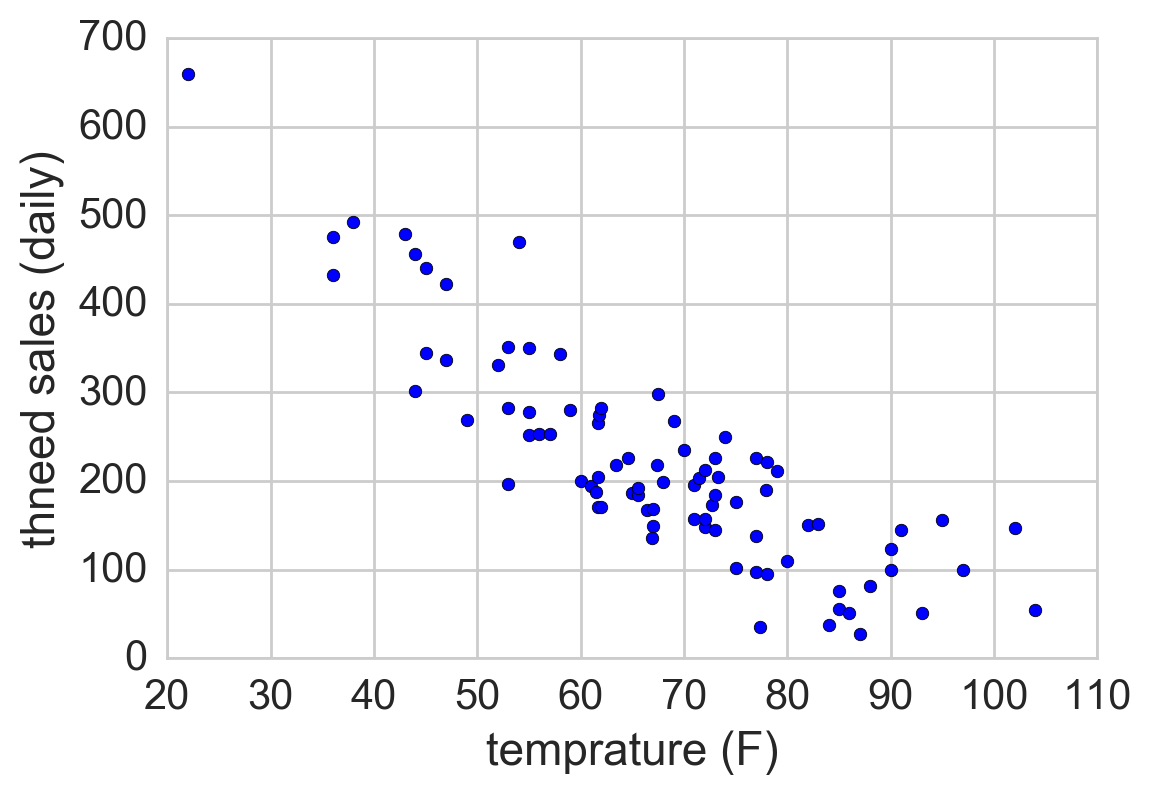

In [15]:
# Grab a reference to fig and axes object so we can reuse them
fig, ax = plt.subplots()

# Plot the Thneed sales data
ax.scatter(df.temp, df.sales)
ax.set_xlim(xmin=20, xmax=110)
ax.set_ylim(ymin=0, ymax=700)
ax.set_xlabel('temprature (F)')
ax.set_ylabel('thneed sales (daily)');

We can see a definite relationship between the two variables temperature and sales, but how can we best model that relationship so we can accurately predict sales based on temperature? 

Well, one measure of a model's accuracy is the [Root-Mean-Square Error (RMSE)][rmse]. This metric represents the sample standard deviation between a set of predicted values (from our model) and the actual observed values. 

[rmse]: https://en.wikipedia.org/wiki/Root-mean-square_deviation

In [16]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets)**2).mean())

We can now use our `rmse` function to measure how well our models' accurately represent the Thneed sales dataset. And, in the next cell, we'll give it a try by creating two different models and seeing which one does a better job of fitting our sales data.

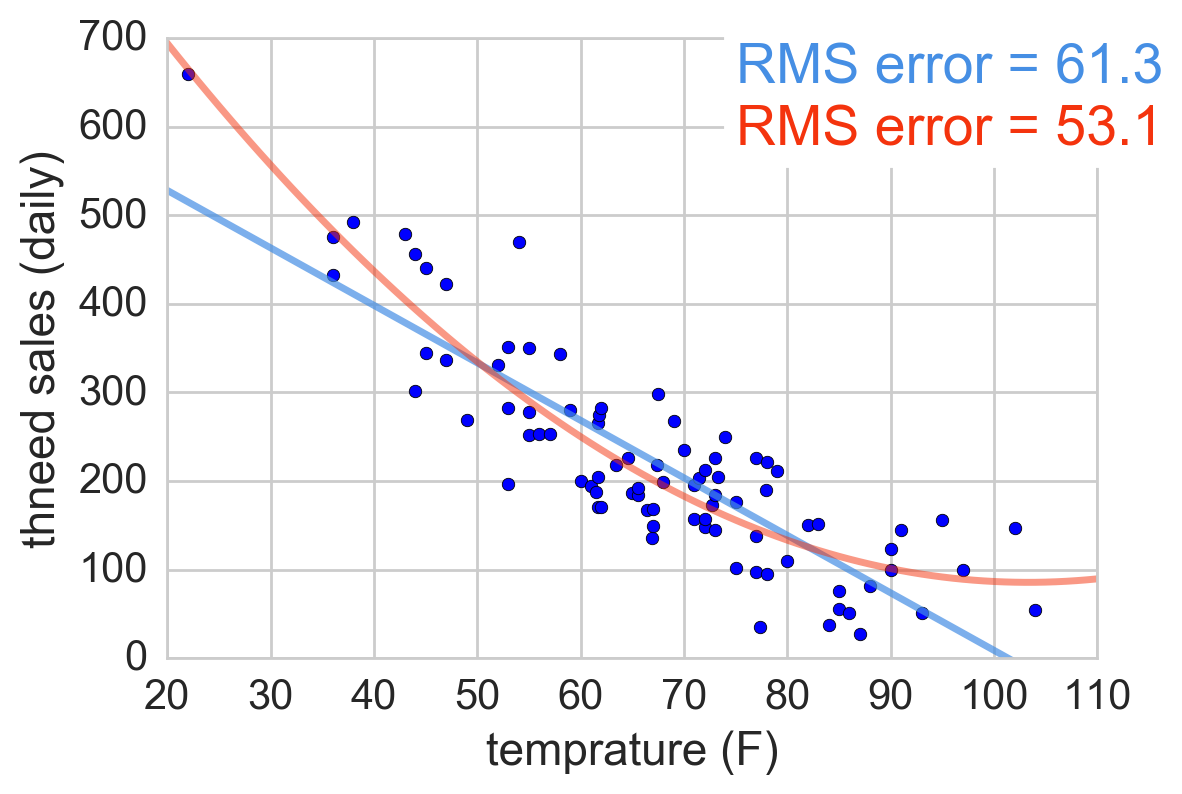

In [17]:
# 1D Polynomial Fit
d1_model = np.poly1d(np.polyfit(df.temp, df.sales, 1))
d1_predictions = d1_model(range(111))
ax.plot(range(111), d1_predictions, 
        color=blue, alpha=0.7)

# 2D Polynomial Fit
d2_model = np.poly1d(np.polyfit(df.temp, df.sales, 2))
d2_predictions = d2_model(range(111))
ax.plot(range(111), d2_predictions, 
        color=red, alpha=0.5)

ax.annotate('RMS error = %2.1f' % rmse(d1_model(df.temp), df.sales),
             xy=(75, 650),
             fontsize=20,
             color=blue,
             backgroundcolor='w')

ax.annotate('RMS error = %2.1f' % rmse(d2_model(df.temp), df.sales),
             xy=(75, 580),
             fontsize=20,
             color=red,
             backgroundcolor='w')

display(fig);

In the figure above, we plotted our sales data along with the two models we created in the previous step. The first model (in blue) is a simple linear model, i.e., a [first-degree polynomial][degree]. The second model (in red) is a second-degree polynomial, so rather than a straight line, we end up with a slight curve. 

We can see from the RMSE values in the figure above that the second-degree polynomial performed better than the simple linear model. Of course, the question you should now be asking is, is this the best possible model that we can find?

To find out, let's take a look at the RMSE of a few more models to see if we can do any better.

[degree]: https://en.wikipedia.org/wiki/Degree_of_a_polynomial

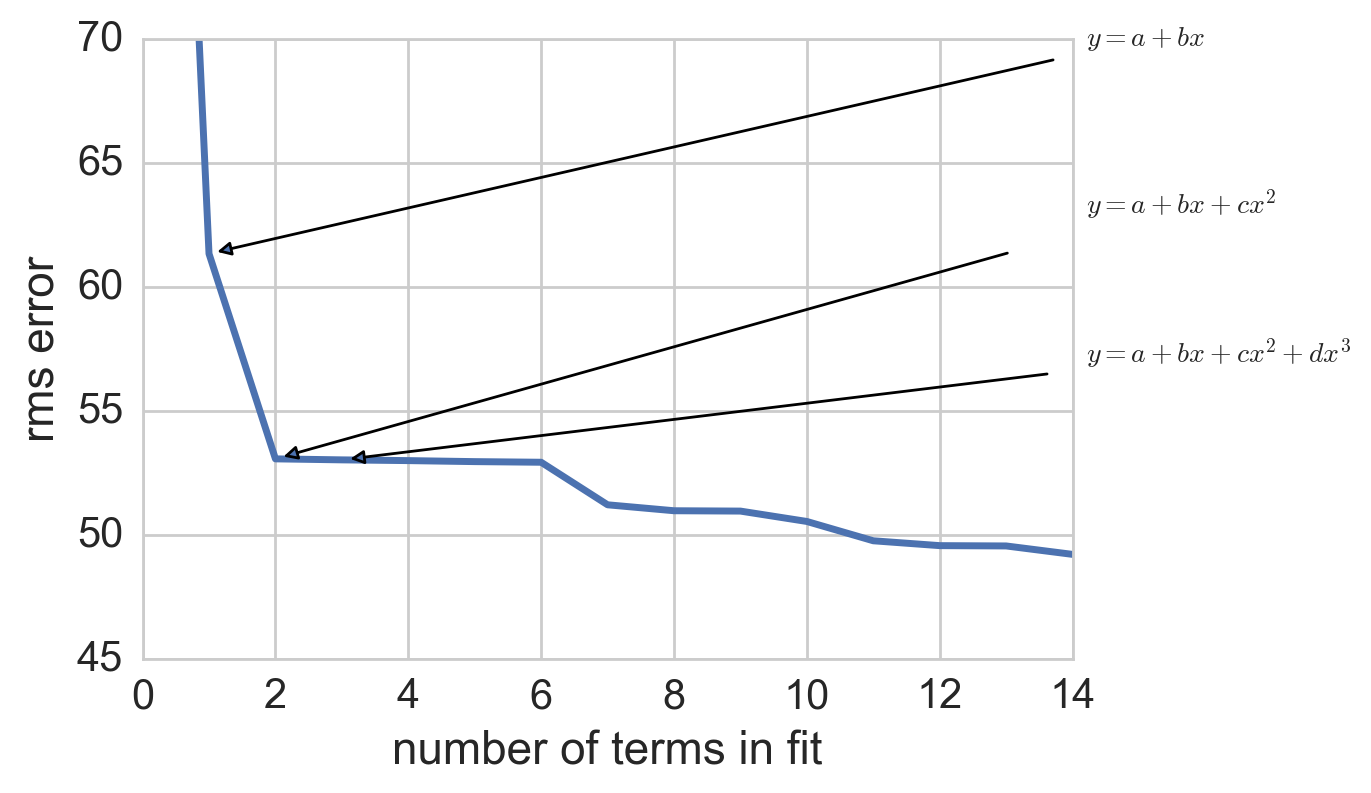

In [18]:
rmses = []
for deg in range(15):
    model = np.poly1d(np.polyfit(df.temp, df.sales, deg))
    predictions = model(df.temp)
    rmses.append(rmse(predictions, df.sales))
    
plt.plot(range(15), rmses)
plt.ylim(45, 70)
plt.xlabel('number of terms in fit')
plt.ylabel('rms error')

plt.annotate('$y = a + bx$', 
             xytext=(14.2, 70), 
             xy=(1, rmses[1]), 
             multialignment='right',
             va='center',
             arrowprops={'arrowstyle': '-|>',
                         'lw': 1,
                         'shrinkA': 10,
                         'shrinkB': 3})

plt.annotate('$y = a + bx + cx^2$', 
             xytext=(14.2, 64), 
             xy=(2, rmses[2]), 
             multialignment='right',
             va='top',
             arrowprops={'arrowstyle': '-|>',
                         'lw': 1,
                         'shrinkA': 35,
                         'shrinkB': 3})


plt.annotate('$y = a + bx + cx^2 + dx^3$', 
             xytext=(14.2, 58), 
             xy=(3, rmses[3]), 
             multialignment='right',
             va='top',
             arrowprops={'arrowstyle': '-|>',
                         'lw': 1,
                         'shrinkA': 12,
                         'shrinkB': 3});

We can see, from the plot above, that as we increase the number of terms (i.e., the degrees of freedom) in our model we decrease the RMSE, and this behavior can continue indefinitely, or until we have as many terms as we do data points, at which point we would be fitting the data perfectly.

The problem with this approach though, is that as we increase the number of terms in our equation, we simply match the given dataset closer and closer, but what if our model were to see a data point that's not in our training dataset?

As you can see in the plot below, the model that we've created, though it has a very low RMSE, it has so many terms that it matches our current dataset too closely.

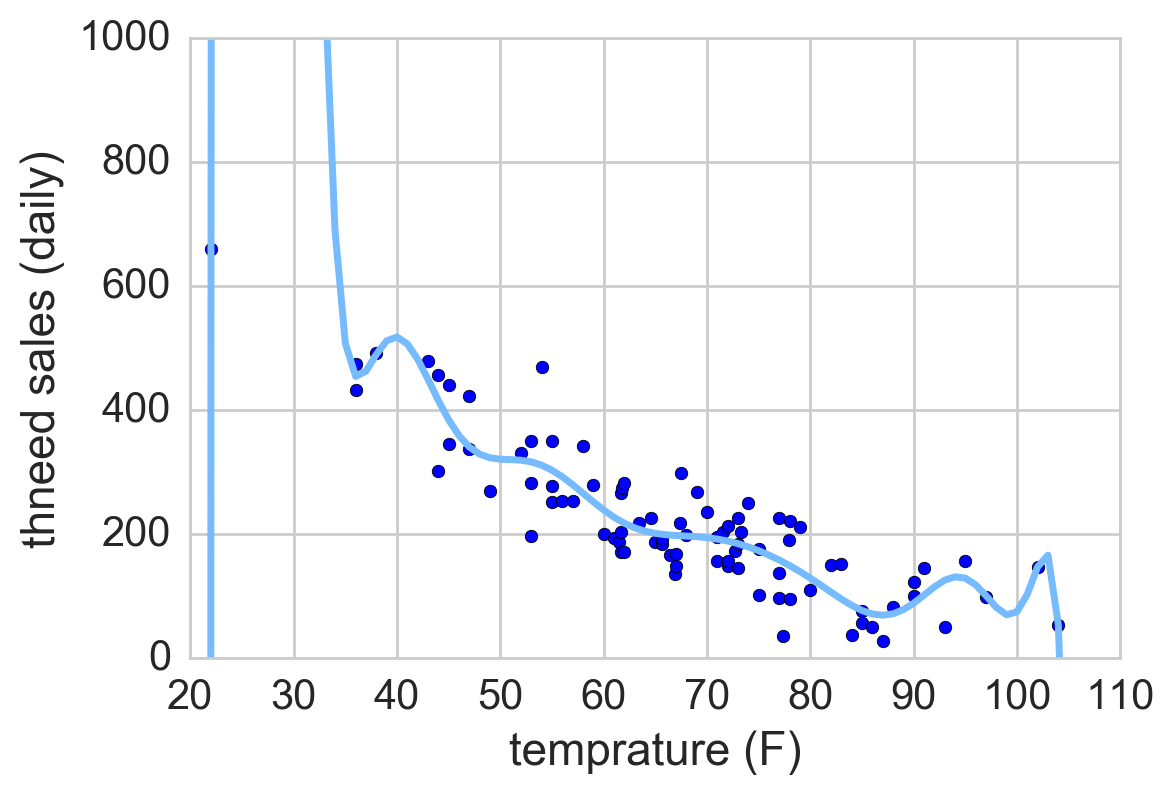

In [19]:
# Remove everything but the datapoints
ax.lines.clear()
ax.texts.clear()

# Changing the y-axis limits to match the figure in the slides
ax.set_ylim(0, 1000)

# 14 Dimensional Model
model = np.poly1d(np.polyfit(df.temp, df.sales, 14))
ax.plot(range(20, 110), model(range(20, 110)),
         color=sns.xkcd_rgb['sky blue'])

display(fig)

The problem with fitting the data too closely, is that our model is so finely tuned to our specific dataset, that if we were to use it to predict future sales, it would most likely fail to get very close to the actual value. This phenomenon of too closely modeling the training dataset is well known amongst machine learning practitioners as [overfitting][overfitting] and one way that we can avoid it is to use [cross-validation][cv]. 

Cross-validation avoids overfitting by splitting the training dataset into several subsets and using each one to train and test multiple models. Then the RMSE's of each of those models are averaged to give a more likely estimate of how a model of that type would perform on unseen data.

So, let's give it a try by splitting our data into two groups and randomly assigning data points into each one.

[overfitting]: https://en.wikipedia.org/wiki/Overfitting
[cv]: https://en.wikipedia.org/wiki/Cross-validation_(statistics)

In [20]:
df_a = df.sample(n=len(df)/2)
df_b = df.drop(df_a.index)

We can take a look at each subset of our data by plotting each one as a different color.

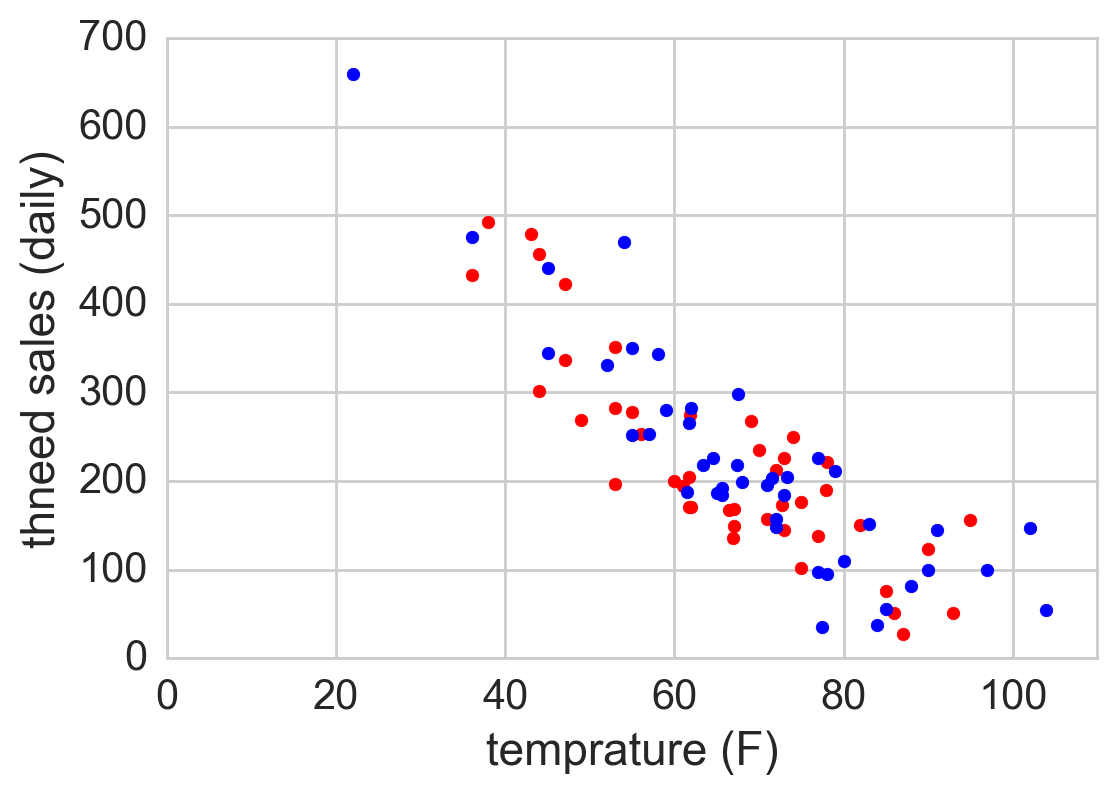

In [21]:
plt.scatter(df_a.temp, df_a.sales, color='red')
plt.scatter(df_b.temp, df_b.sales, color='blue')
plt.xlim(0, 110)
plt.ylim(0, 700)
plt.xlabel('temprature (F)')
plt.ylabel('thneed sales (daily)');

Then, we'll find the best model for each subset of data. In this particular example, we'll fit a second-degree polynomial to each subset and plot both below.

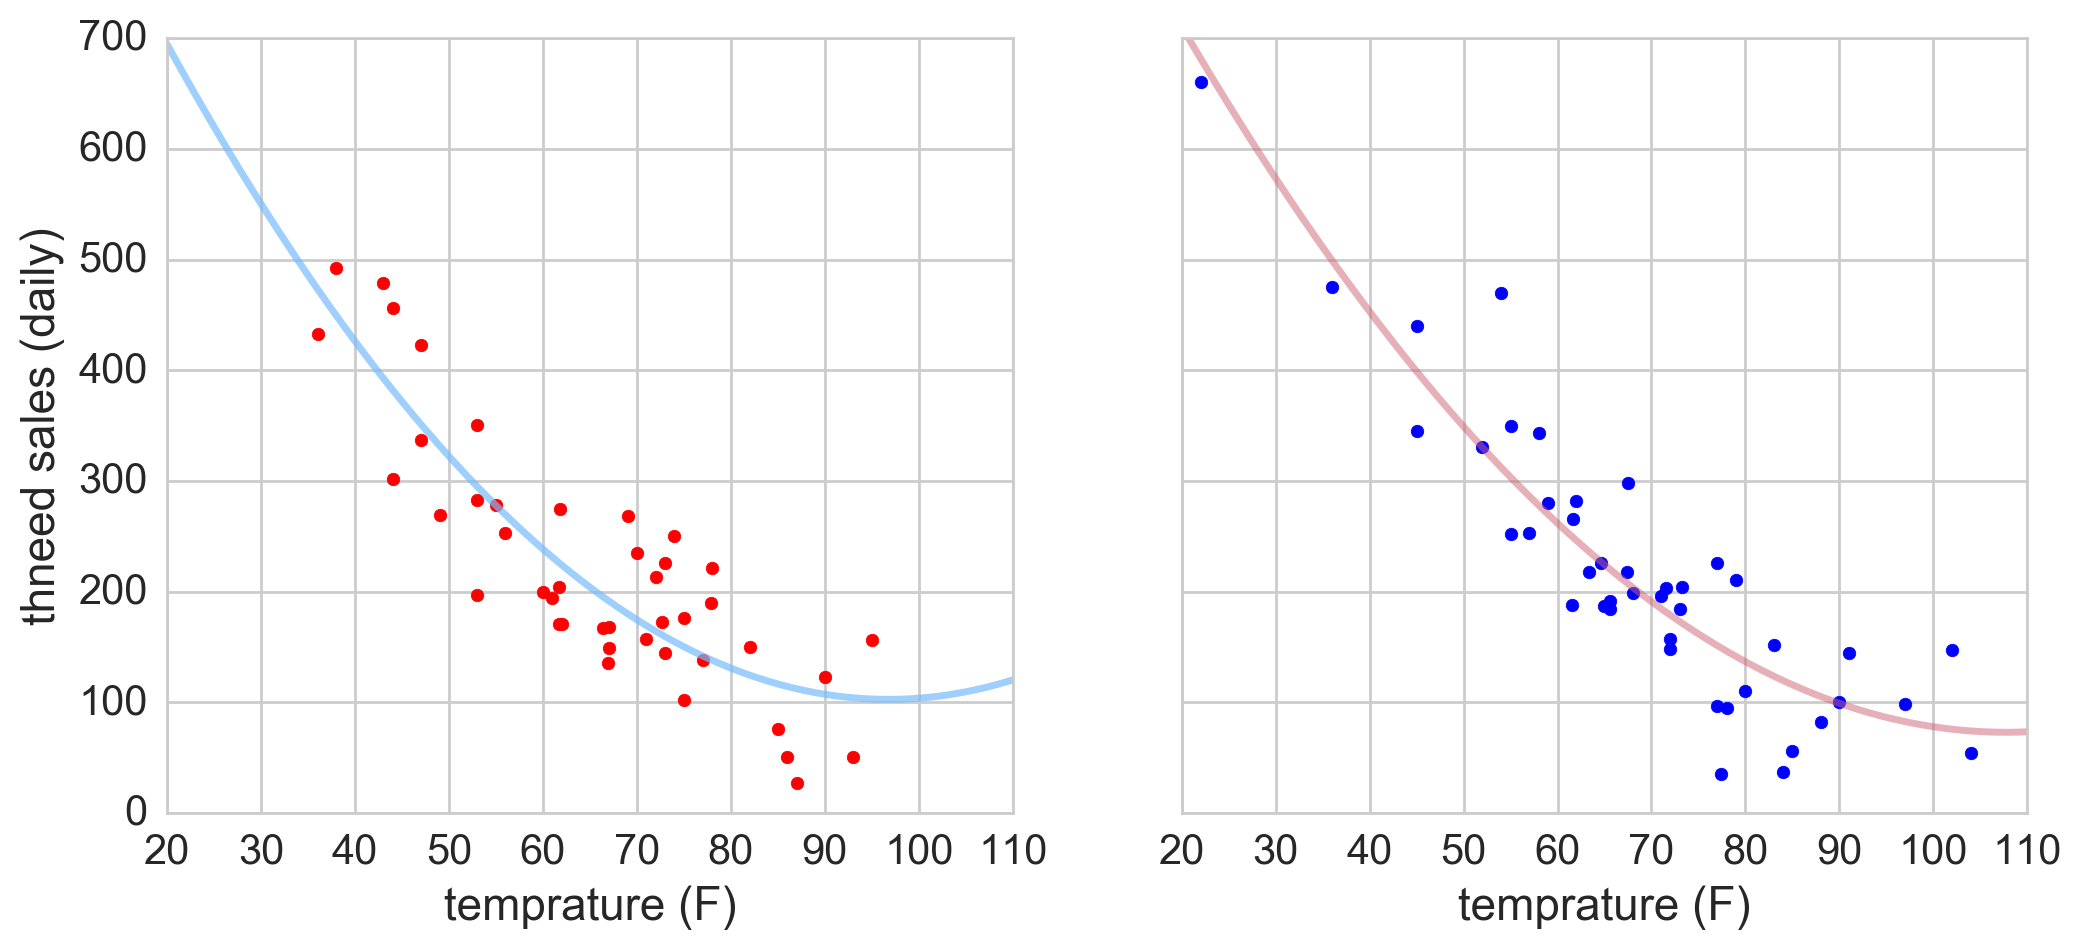

In [22]:
# Create a 2-degree model for each subset of data
m1 = np.poly1d(np.polyfit(df_a.temp, df_a.sales, 2))
m2 = np.poly1d(np.polyfit(df_b.temp, df_b.sales, 2))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, 
                               sharex=False, sharey=True,
                               figsize=(12, 5))

x_min, x_max = 20, 110
y_min, y_max = 0, 700
x = range(x_min, x_max + 1)

# Plot the df_a group
ax1.scatter(df_a.temp, df_a.sales, color='red')
ax1.set_xlim(xmin=x_min, xmax=x_max)
ax1.set_ylim(ymin=y_min, ymax=y_max)
ax1.set_xlabel('temprature (F)')
ax1.set_ylabel('thneed sales (daily)')
ax1.plot(x, m1(x),
         color=sns.xkcd_rgb['sky blue'],
         alpha=0.7)

# Plot the df_b group
ax2.scatter(df_b.temp, df_b.sales, color='blue')
ax2.set_xlim(xmin=x_min, xmax=x_max)
ax2.set_ylim(ymin=y_min, ymax=y_max)
ax2.set_xlabel('temprature (F)')
ax2.plot(x, m2(x),
         color=sns.xkcd_rgb['rose'], 
         alpha=0.5);

Finally, we'll compare models across subsets by calculating the RMSE for each model using the training set for the other model. This will give us two RMSE scores which we'll then average to get a more accurate estimate of how well a second-degree polynomial will perform on any unseen data.

In [23]:
print("RMS = %2.1f" % rmse(m1(df_a.temp), df_a.sales))
print("RMS = %2.1f" % rmse(m2(df_b.temp), df_b.sales))
print("RMS estimate = %2.1f" % np.mean([rmse(m1(df_a.temp), df_a.sales),
                                        rmse(m2(df_b.temp), df_b.sales)]))

RMS = 53.5
RMS = 50.9
RMS estimate = 52.2


Then, we simply repeat this process for as long as we so desire. 

The following code repeats the process described above for polynomials up to 14 degrees and plots the average RMSE for each one against the non-cross-validated RMSE's that we calculated earlier.

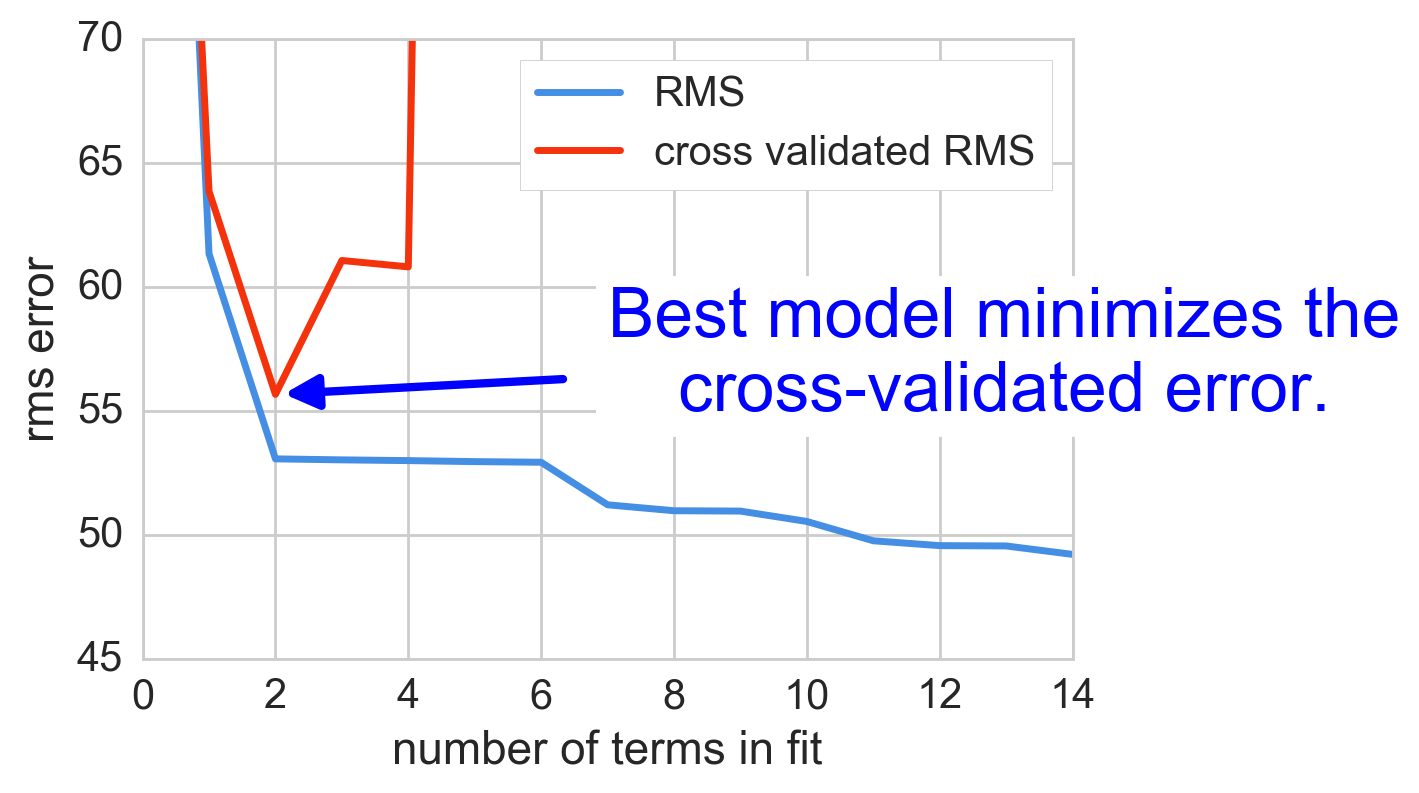

In [24]:
rmses = []
cross_validated_rmses = []
for deg in range(15):
    # df_a the model on the whole dataset and calculate its
    # RMSE on the same set of data
    model = np.poly1d(np.polyfit(df.temp, df.sales, deg))
    predictions = model(df.temp)
    rmses.append(rmse(predictions, df.sales))
    
    # Use cross-validation to create the model and df_a it
    m1 = np.poly1d(np.polyfit(df_a.temp, df_a.sales, deg))
    m2 = np.poly1d(np.polyfit(df_b.temp, df_b.sales, deg))
    
    p1 = m1(df_b.temp)
    p2 = m2(df_a.temp)
    
    cross_validated_rmses.append(np.mean([rmse(p1, df_b.sales), 
                                          rmse(p2, df_a.sales)]))

    
plt.plot(range(15), rmses, color=blue, 
         label='RMS')
plt.plot(range(15), cross_validated_rmses, color=red, 
         label='cross validated RMS')
plt.ylim(45, 70)
plt.xlabel('number of terms in fit')
plt.ylabel('rms error')
plt.legend(frameon=True)

plt.annotate('Best model minimizes the\ncross-validated error.', 
             xytext=(7, 60), 
             xy=(2, cross_validated_rmses[2]), 
             multialignment='center',
             va='top',
             color='blue',
             size=25,
             backgroundcolor='w',
             arrowprops={'arrowstyle': '-|>',
                         'lw': 3,
                         'shrinkA': 12,
                         'shrinkB': 3,
                         'color': 'blue'});

According to the graph above, going from a 1-degree to a 2-degree polynomial gives us quite a large improvement overall. But, unlike the RMSE that we calculated against the training set, when using cross-validation we can see that adding more degrees of freedom to our equation quickly reduces the effectiveness of the model against unseen data. This is overfitting in action! In fact, from the looks of the graph above, it would seem that a second-degree polynomial is actually our best bet for this particular dataset.

#### 2-Fold Cross-Validation

Several different methods for performing cross-validation exist, the one we've just seen is called [2-fold cross-validation][2-fold-cv] since the data is split into two subsets. Another close relative is a method called [$k$-fold cross-validation][k-fold-cv]. It differs slightly in that the original dataset is divided into $k$ subsets (instead of just 2), one of which is reserved strictly for testing and the other $k - 1$ subsets are used for training models. This is just one example of an alternate cross-validation method, but more do exist and each one has advantages and drawbacks that you'll need to consider when deciding which method to use.

[2-fold-cv]: https://en.wikipedia.org/wiki/Cross-validation_(statistics)#2-fold_cross-validation
[k-fold-cv]: https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation

## Conclusion

Ok, so that covers nearly everything that Jake covered in his talk. The end of the talk contains a short overview of some important areas that he didn't have time to cover, and there's a nice set of Q&A at the end, but I'll simply direct you to the [video][video] for those parts of the talk. Hopefully, this article/notebook has been helpful to anyone working their way through Jake's talk, and if for some reason, you've read through this entire article and haven't watched the video of the talk yet, I encourage you to take 40 minutes out of your day and go [watch it now][video], it really is a fantastic talk!

[video]: https://youtu.be/Iq9DzN6mvYA